In [49]:
import datashader as ds


In [50]:
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy

In [51]:
from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

In [52]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
plotly.tools.set_credentials_file(username='jagso', api_key= 's9kYa9XZHu8ptc5ioSNK')
from shapely.geometry import Point, Polygon, shape


In [53]:
from functools import partial

from IPython.display import GeoJSON

In [54]:
bk = pd.read_csv('PLUTO_for_WEB/BK_18V1.csv')
bx = pd.read_csv('PLUTO_for_WEB/BX_18v1.csv')
mn = pd.read_csv('PLUTO_for_WEB/MN_18V1.csv')
qn = pd.read_csv('PLUTO_for_WEB/QN_18V1.csv')
si = pd.read_csv('PLUTO_for_WEB/SI_18V1.csv')


/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (20,23,24,26,64) have mixed types. Specify dtype option on import or set low_memory=False.

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.

/Applications/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,23,24,64,65,80) have mixe

In [56]:
ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)
# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]
ny.head()

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearAlter1,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap
1,0.0,NaN,10 JAY STREET,2,834300,13780800,3000010050,163894,O6,195.0,...,1994,2015,1920,NaN,11201.0,M1-4/R8A,M3-1,NaN,NaN,12d
16,0.0,NaN,1 PLYMOUTH STREET,2,129600,430200,3000070021,9585,P5,113.0,...,1988,0,1988,NaN,11201.0,M3-1,NaN,NaN,NaN,12d
19,0.0,NaN,65 PLYMOUTH STREET,2,178200,213750,3000160005,5000,Q0,165.0,...,0,0,1920,NaN,11201.0,PARK,NaN,NaN,NaN,12d
21,0.0,NaN,135 PLYMOUTH STREET,2,514350,8307000,3000180001,211386,D7,48.0,...,2014,0,1900,NaN,11201.0,M1-4/R8A,NaN,NaN,NaN,12d
22,0.0,NaN,20 JAY STREET,2,972000,42978600,3000190001,500000,O6,207.0,...,1999,0,1911,NaN,11201.0,M1-4/R8A,NaN,NaN,NaN,12d


In [34]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

In [35]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jagso/0 or inside your plot.ly account where it is named 'ny-year-built'


After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [82]:
ny['YearBuiltDatetime'] = pd.to_datetime(ny['YearBuilt'], format = '%Y')
ny_groupByYear = ny.groupby('YearBuiltDatetime').count()['BBL']
Buildindecade = ny[['YearBuilt', 'NumFloors', 'BBL']]
Buildindecade['YearBuilt'] = (np.ceil(Buildindecade['YearBuilt'] / 10)* 10)
trace = go.Scatter(
    x = Buildindecade.groupby('YearBuilt').count()['NumFloors'].index,
    y = Buildindecade.groupby('YearBuilt').count()['BBL'],
    
        
        )
layout = go.Layout(
    xaxis = dict(title = 'Built Time'),
    yaxis = dict(title = 'Number of Building floors')
)

fig = go.Figure(data = [trace], layout = layout)


py.iplot(fig, filename = 'ny-year-built-5bin')

Part 2: Datashader
Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [89]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook Plotting Perils.

Here is what the same plot would look like in datashader:

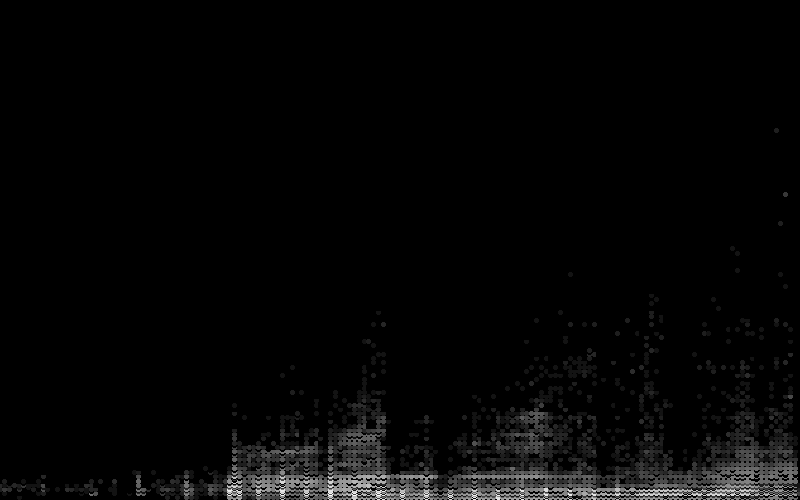

In [93]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



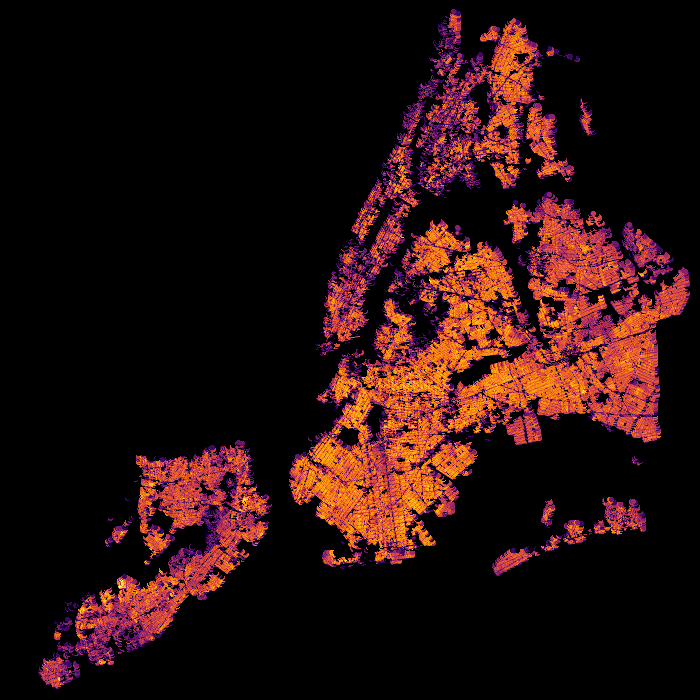

In [94]:
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. This talk also provides a nice background for datashader. Feel free to use my samples as templates as well when you work on this problem.

Question
You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

In [99]:
nytax = ny[['BBL', 'lon', 'lat', 'AssessLand','AssessTot']]
nytax['AssessProp'] = nytax['AssessTot'] - nytax['AssessLand']
nytax.head()

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,BBL,lon,lat,AssessLand,AssessTot,AssessProp
1,3000010050,-73.987066,40.704619,834300,13780800,12946500
16,3000070021,-73.989310,40.704109,129600,430200,300600
19,3000160005,-73.990608,40.704581,178200,213750,35550
21,3000180001,-73.988008,40.704131,514350,8307000,7792650
22,3000190001,-73.987077,40.704101,972000,42978600,42006600


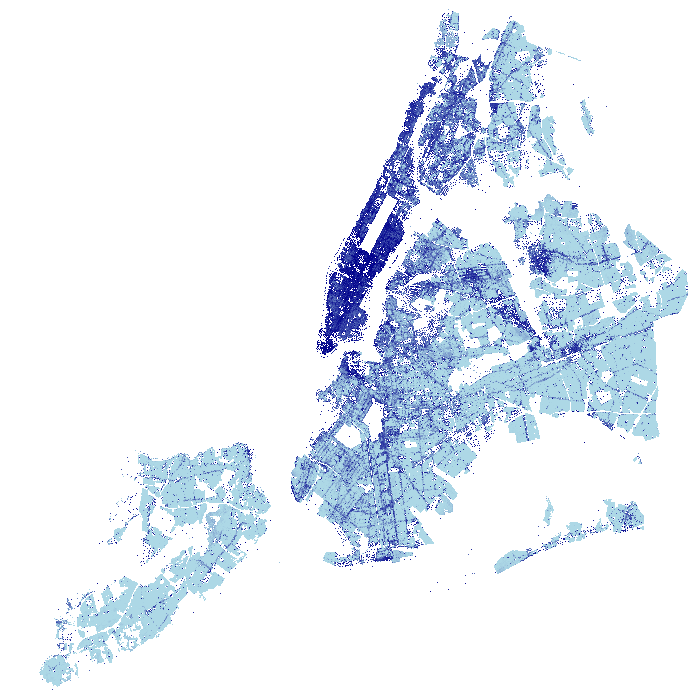

In [104]:
reduction = reductions.count()
glyph = ds.glyphs.Point('lon', 'lat')
canvas = cvs
agg = bypixel(nytax, canvas, glyph, reduction)
tf.shade(canvas.points(nytax,'lon','lat',agg=reductions.mean('AssessProp')))